In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('final_df.csv')

In [3]:
df = df.drop(columns='Unnamed: 0')

In [4]:
np.abs(df.corr()['Target']).sort_values(ascending=False)

Target                             1.000000
Thalassemia_2                      0.526030
Thalassemia_3                      0.484887
Exercise_Indused_Angina            0.435601
Max_Heart_Rate                     0.419955
Slope_2                            0.392121
Oldpeak                            0.360400
Slope_1                            0.360258
Chest_Pain_Type_Non-Anginal        0.313696
Gender                             0.283609
Major_Vessels_2                    0.273295
Age_old                            0.265888
Chest_Pain_Type_Atypical Angina    0.247649
Age_middle                         0.238003
Major_Vessels_1                    0.231255
Major_Vessels_3                    0.210126
Resting_ECG_1                      0.172827
Resting_Blood_Pressure             0.146269
Thalassemia_1                      0.105986
Chest_Pain_Type_Asymptomatic       0.087959
Serum_Cholesterol                  0.081437
Resting_ECG_2                      0.068156
Major_Vessels_4                 

## Splitting and Scaling

In [5]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('Target', axis=1) # grabs everything else but 'Default'

# Create target variable
y = df['Target'] # y is the column we're trying to predict

In [6]:
#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=30)

In [7]:
# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = X.columns)

## Logistic Regression 

In [8]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight = 'balanced')

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)


base_logreg_recall = metrics.recall_score(y_test, base_logred_test_pred)
base_logred_train_f1_score = f1_score(y_train, base_logred_train_pred)
base_logreg_test_f1_score = f1_score(y_test, base_logred_test_pred)


print('Recall Score: ', base_logreg_recall)
print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)

Recall Score:  0.8444444444444444
Train F1 score:  0.9045643153526971
Test F1 score:  0.8260869565217391


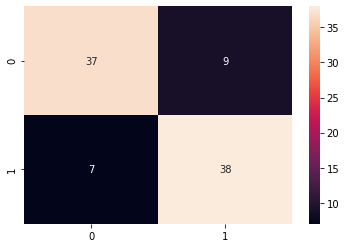

In [9]:
cm = confusion_matrix(y_test,base_logred_test_pred)
sns.heatmap(cm,annot=True);

## Recursive Feature Elimination

In [10]:
from sklearn.feature_selection import RFECV
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=logreg, step=1, cv=5, scoring='recall', n_jobs=-1,verbose=1)

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.


RFECV(cv=5, estimator=LogisticRegression(class_weight='balanced'), n_jobs=-1,
      scoring='recall', verbose=1)

In [11]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [12]:
selected_rfe

Index(['Gender', 'Resting_Blood_Pressure', 'Serum_Cholesterol',
       'Fasting_Blood_Sugar', 'Max_Heart_Rate', 'Exercise_Indused_Angina',
       'Oldpeak', 'Serum_Cholesterol_Level', 'Age_middle', 'Slope_2',
       'Major_Vessels_1', 'Major_Vessels_2', 'Major_Vessels_3',
       'Major_Vessels_4', 'Thalassemia_1', 'Thalassemia_2',
       'Chest_Pain_Type_Atypical Angina', 'Chest_Pain_Type_Non-Anginal',
       'Chest_Pain_Type_Asymptomatic'],
      dtype='object')

In [13]:
logreg_rfe = LogisticRegression(class_weight = 'balanced')
logreg_rfe = logreg_rfe.fit(X_train[selected_rfe], y_train)


logred_rfe_train_pred = logreg_rfe.predict(X_train[selected_rfe])
logred_rfe_test_pred = logreg_rfe.predict(X_test[selected_rfe])


base_logreg_rfe_recall = metrics.recall_score(y_test, logred_rfe_test_pred)
base_logred_rfe_train_f1_score = f1_score(y_train, logred_rfe_train_pred)
base_logreg_rfe_test_f1_score = f1_score(y_test, logred_rfe_test_pred)


print('Recall Score: ', base_logreg_rfe_recall)
print('Train F1 score: ', base_logred_rfe_train_f1_score)
print('Test F1 score: ', base_logreg_rfe_test_f1_score)

Recall Score:  0.8444444444444444
Train F1 score:  0.8962655601659751
Test F1 score:  0.8260869565217391


## KNN

Maximum accuracy:- 0.9333333333333333 at K = 10


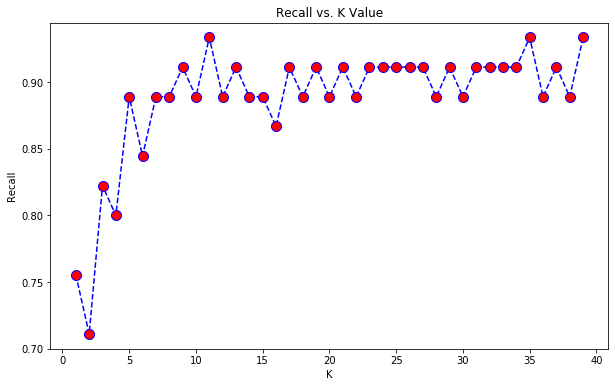

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Will take some time
acc = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    acc.append(metrics.recall_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Recall vs. K Value')
plt.xlabel('K')
plt.ylabel('Recall')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [15]:
knn = KNeighborsClassifier(n_neighbors=40)

knn.fit(X_train,y_train)

KNN_train_preds = knn.predict(X_train)
KNN_preds = knn.predict(X_test)

In [16]:
KNN_recall = metrics.recall_score(y_test, KNN_preds)
KNN_train_f1_score = f1_score(y_train, KNN_train_preds)
KNN_f1_score = f1_score(y_test, KNN_preds)


print('Recall Score: ', KNN_recall)
print('Train F1 score: ', KNN_train_f1_score)
print('Test F1 score: ', KNN_f1_score)

Recall Score:  0.9111111111111111
Train F1 score:  0.8537549407114625
Test F1 score:  0.845360824742268


In [17]:
print('KNN Classification Report')
print(classification_report(y_test,KNN_preds))

KNN Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82        46
         1.0       0.79      0.91      0.85        45

    accuracy                           0.84        91
   macro avg       0.84      0.84      0.83        91
weighted avg       0.84      0.84      0.83        91



## Decision Tree

In [18]:
# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

clf = DecisionTreeClassifier(random_state=1, criterion = 'gini', max_depth = 7, min_samples_leaf = 7, min_samples_split = 2)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

clf_f1_train = round(f1_score(y_train, y_pred_train), 3)
clf_f1_test = round(f1_score(y_test, y_pred), 3)
clf_recall = round(metrics.recall_score(y_test, y_pred), 3)

print('Recall Score: ', clf_recall)
print('Train F1 score: ', clf_f1_train)
print('Test F1 score: ', clf_f1_test)

Recall Score:  0.844
Train F1 score:  0.844
Test F1 score:  0.792


[0.04269605 0.06649827 0.06849988 0.02096662 0.08038706 0.07797273
 0.04568273 0.01469197 0.02327541 0.03791753 0.03507951 0.00317656
 0.03839901 0.05073286 0.04480808 0.03149576 0.02320992 0.00275503
 0.0079239  0.09945412 0.08498378 0.02424609 0.04915972 0.02598741]


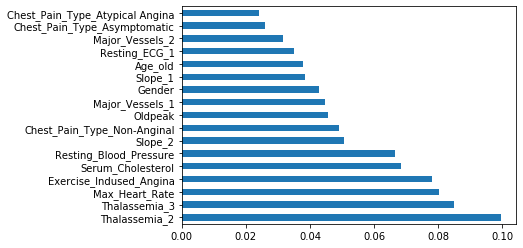

In [19]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

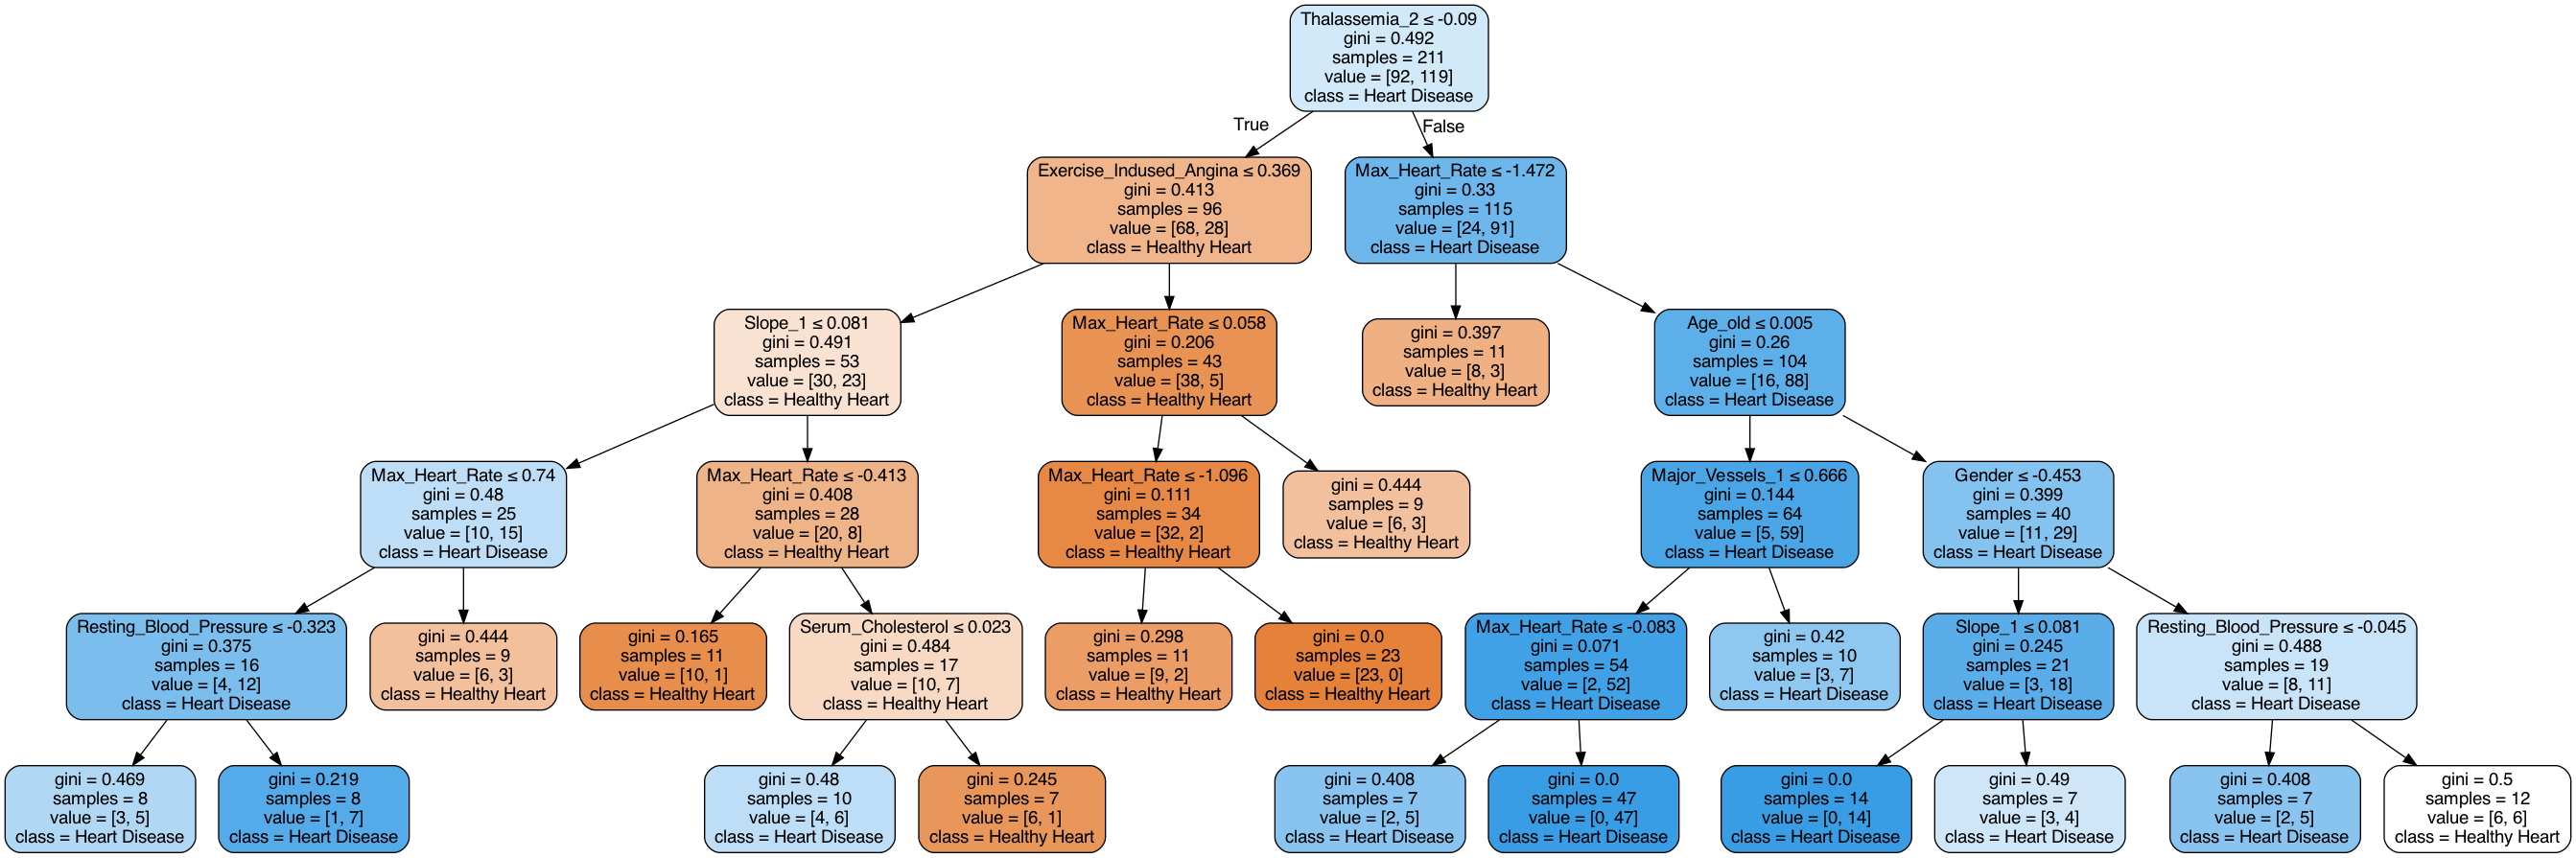

In [20]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['Healthy Heart','Heart Disease'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

## Decision Tree w/ Gridsearch

In [21]:
from sklearn.model_selection import GridSearchCV
d_tree = DecisionTreeClassifier()
parameters = {"max_depth":range(15,25,1),
              "criterion":["entropy"], 
              "min_samples_leaf":range(50,80,5),
              "splitter":["best"],
              "max_features":range(1,28)}
d_tree_grid = GridSearchCV(d_tree,param_grid=parameters,scoring='recall',n_jobs=-1,cv=5,verbose=1)

In [22]:
d_tree_grid.fit(X_train,y_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2500 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 6500 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed:   23.5s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(15, 25),
                         'max_features': range(1, 28),
                         'min_samples_leaf': range(50, 80, 5),
                         'splitter': ['best']},
             scoring='recall', verbose=1)

In [23]:
print(d_tree_grid.best_score_)
print(d_tree_grid.best_params_)
print(d_tree_grid.best_estimator_)

1.0
{'criterion': 'entropy', 'max_depth': 18, 'max_features': 1, 'min_samples_leaf': 75, 'splitter': 'best'}
DecisionTreeClassifier(criterion='entropy', max_depth=18, max_features=1,
                       min_samples_leaf=75)


In [24]:
y_pred_d_tree_train = d_tree_grid.best_estimator_.predict(X_train)
y_pred_d_tree = d_tree_grid.best_estimator_.predict(X_test)

In [25]:
gcv_decision_tree_recall_score = metrics.recall_score(y_test, y_pred_d_tree)
gcv_decision_tree_f1_score = f1_score(y_test, y_pred_d_tree)
gcv_decision_tree_f1_train_score = f1_score(y_train, y_pred_d_tree_train)

print('Test Recall score: ', gcv_decision_tree_recall_score)
print('Train F1 score: ', gcv_decision_tree_f1_train_score)
print('Test F1 score: ', gcv_decision_tree_f1_score)

Test Recall score:  0.6222222222222222
Train F1 score:  0.7027027027027027
Test F1 score:  0.6746987951807228


## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_recall_score = metrics.recall_score(y_test, rfc_predicted)

In [27]:
rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)
rfc_recall = round(metrics.recall_score(y_test, rfc_predicted), 3)

print('Recall Score: ', rfc_recall)
print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

Recall Score:  0.889
Train F1 score:  0.922
Test F1 score:  0.86


In [28]:
print("Recall of Random Forest:",rfc_recall_score*100,'\n')
print(classification_report(y_test,rfc_predicted))

Recall of Random Forest: 88.88888888888889 

              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85        46
         1.0       0.83      0.89      0.86        45

    accuracy                           0.86        91
   macro avg       0.86      0.86      0.86        91
weighted avg       0.86      0.86      0.86        91



## Random Forest w/ Gridsearch

In [38]:
# Random forest
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# find the best hyperparameters 
params_rf={'n_estimators':[700],
           'criterion':['gini','entropy'],
           'max_depth':[7],
           'min_samples_leaf':[1],
           'max_leaf_nodes':[12,15,18,20.5,0.25],
           'max_features':[7], 
           'warm_start': [True, False] }

forest = RandomForestClassifier()

tree_g = GridSearchCV(forest, params_rf, cv=2, scoring='f1', verbose = 1,  n_jobs = -1)
tree_g.fit(X_train,y_train)

print(tree_g.best_params_, ': ', tree_g.best_score_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   13.0s finished


{'criterion': 'gini', 'max_depth': 7, 'max_features': 7, 'max_leaf_nodes': 18, 'min_samples_leaf': 1, 'n_estimators': 700, 'warm_start': True} :  0.8000133280021324


## XG BOOST

In [29]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=1)
params={'max_depth':[1,3,5,7],'learning_rate':[.01,.1,.5,1], 'max_delta_step':[1,3,5,7],
       'booster':['gbtree']}

xgb_grid=GridSearchCV(xgb_clf,params,cv=3,verbose=1,scoring='recall',n_jobs=-1)

In [30]:
xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 185 out of 192 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    3.4s finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=1,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [31]:
xgb_grid.best_score_

0.8408119658119659

# Final Grades

In [32]:
print('Baseline Logistic Regression:')
print('Recall Score: ', base_logreg_recall)
print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)
print('')
print('Logistic Regression w/ Recursive Feature Elimination:')
print('Recall Score: ', base_logreg_rfe_recall)
print('Train F1 score: ', base_logred_rfe_train_f1_score)
print('Test F1 score: ', base_logreg_rfe_test_f1_score)
print('')
print('KNN:')
print('Recall Score: ', KNN_recall)
print('Train F1 score: ', KNN_train_f1_score)
print('Test F1 score: ', KNN_f1_score)
print('')
print('Decision Tree:')
print('Recall Score: ', clf_recall)
print('Train F1 score: ', clf_f1_train)
print('Test F1 score: ', clf_f1_test)
print('')
print('Decision Tree w/ Gridsearch:')
print('Test Recall score: ', gcv_decision_tree_recall_score)
print('Train F1 score: ', gcv_decision_tree_f1_train_score)
print('Test F1 score: ', gcv_decision_tree_f1_score)
print('')
print('Random Forest:')
print('Recall Score: ', rfc_recall)
print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

Baseline Logistic Regression:
Recall Score:  0.8444444444444444
Train F1 score:  0.9045643153526971
Test F1 score:  0.8260869565217391

Logistic Regression w/ Recursive Feature Elimination:
Recall Score:  0.8444444444444444
Train F1 score:  0.8962655601659751
Test F1 score:  0.8260869565217391

KNN:
Recall Score:  0.9111111111111111
Train F1 score:  0.8537549407114625
Test F1 score:  0.845360824742268

Decision Tree:
Recall Score:  0.844
Train F1 score:  0.844
Test F1 score:  0.792

Decision Tree w/ Gridsearch:
Test Recall score:  0.6222222222222222
Train F1 score:  0.7027027027027027
Test F1 score:  0.6746987951807228

Random Forest:
Recall Score:  0.889
Train F1 score:  0.922
Test F1 score:  0.86
